In [1]:

import numpy as np
import matplotlib.pyplot as plt 
import scipy

import sys
sys.path.append("/home/calab912/Documents/fdm-hybrid-scheme/")

import src.fd as fd 
import src.config as config
import src.animation as animation 
import demonstration.spectral_derivative as sd 

In [55]:
if 1:
    mreal    = np.single
    mcomplex = np.csingle
else:
    mreal = np.double
    mcomplex = np.cdouble
    
# Generate analytical solution for the 1D free Schrödinger equation
# Li test 1
def generate1DGaussian(x0, x, t, m = 1, hbar = 1, alpha=1.0 / 10):
    psi = np.sqrt(1 / (alpha + 1.0j * t * hbar/m)) * np.exp(
        -((x - x0) ** 2) / (2 * (alpha + 1.0j * t * hbar/m))
    )
    return psi

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=5, alpha= 1/20, eps=0, L=10, N=100):
    psi = eps + 0j
    N = 40
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

class Scheme:
    def __init__(self, config, generateIC):

        #print(f"Constructing {self.getName()} scheme")

        self.config              = config
        self.generateIC          = generateIC

        # Set up time management
        self.t0                  = config["t0"]
        self.t                   = config["t0"]
        self.dt                  = config["dt"]
        self.tEnd                = config["tEnd"]
        self.useAdaptiveTimestep = config["useAdaptiveTimestep"]
        self.outputTimestep      = config["outputTimestep"]
        self.timeOrder           = config["timeOrder"]
        self.cfl                 = config["cfl"]
        self.ntmax               = config["maximumNumberOfTimesteps"]



        # Set up grid (evenly-spaced with or without ghost boundary)
        self.dimension           = config["dimension"]
        self.stencilOrder        = config["stencilOrder"] 

        #Since we use np.roll for finite differences there is no need for a ghost boundary with periodic boundary conditions
        self.usePeriodicBC     = config["usePeriodicBC"]
        self.ghostBoundarySize = config["boundarySize"]

        self.useBC = config["useBC"]

        # Set up simulation grid
        N                = config["resolution"]
        self.L0, self.L1 = config["domainSize"]
        self.boxWidth  = self.L1 - self.L0 # physical box width

        self.innerN    = N
        self.dx        = self.boxWidth / (N - 1)

        #Handle ghost boundary
        self.totalN    = self.innerN + 2 * self.ghostBoundarySize
        N              = self.totalN
        Ll             = self.L0 - self.dx * self.ghostBoundarySize
        Lh             = self.L1 + self.dx * self.ghostBoundarySize
        self.PLMWidth  = Lh - Ll # PLM box width

        #Position of lower and upper grid boundary
        self.Ll = Ll 
        self.Lh = Lh 
        

        self.boundaryColumns = np.concatenate([np.arange(self.ghostBoundarySize), \
                                            np.arange(self.innerN + self.ghostBoundarySize, self.innerN + 2 * self.ghostBoundarySize)])
        self.innerColumns    = np.arange(self.ghostBoundarySize, self.innerN + self.ghostBoundarySize)


        self.boundary = np.ix_(self.boundaryColumns)
        self.inner    = np.ix_(self.innerColumns)

        #Create 1D grid
        xlin, self.dx = sd.computeX(self.Ll, self.Lh, self.totalN)
        self.grid = [xlin]

        self.debug = config["debug"]       
        self.hbar  = config["hbar"]
        self.m     = config["m"]
        self.eta   = self.hbar / self.m
        

        # Set up global parameters and constants
        self.G            = config["gravity"]
        self.useCosmology = config["useCosmology"]
        self.useHybrid    = False


        self.C_potential       = config["C_potential"]
        self.C_parabolic       = config["C_parabolic"]



        self.dt            = self.getTimeStep()
        
        self.psi           = self.generateIC(*self.grid, self.dx, self.t          , self.m, self.hbar)
        self.potential     = np.zeros(self.psi.shape)
        self.fields        = self.psi

        #Initialise buffer for fields at t - dt for leapfrog method
        self.old_fields    = self.generateIC(*self.grid, self.dx, self.t - self.dt, self.m, self.hbar)


    def getGrid(self):
        return self.grid

    def getTime(self):
        return self.t

    def getTimeStep(self): 
        if self.useAdaptiveTimestep:
            return self.getAdaptiveTimeStep()
        else:
            return self.dt 

    def getAdaptiveTimeStep(self):
        raise NotImplementedError("Please Implement this method")

    def getConfig(self):
        return self.config

    def getUpdatedFields(self, dt, fields):
        raise NotImplementedError("Please Implement this method")

    def setBoundaryConditions(self, fields):
        raise NotImplementedError("Please Implement this method")

    def getScaleFactor(self):
        return 1

    def run(self, tfin = None, enableBackward = False):
        if tfin is None:
            tfin = self.tEnd
        i = 0
        while(self.t < tfin - 1e-15):
            dt = self.getTimeStep()

            if (tfin - self.t < dt):
                dt = tfin - self.t

            self.step(dt)
            i += 1
            if i > self.ntmax:
                print("Maximum number of timesteps reached. Aborting.")
                break
        
        if enableBackward:
            while(tfin < self.t):
                dt = self.getTimeStep()

                if (self.t - tfin < dt):
                    dt = self.t - tfin

                self.step(-dt)
                i += 1
                if i > self.ntmax:
                    print("Maximum number of timesteps reached. Aborting.")
                    break
        print(f"Finished in {i} time steps")


    #Dummy function for implementation of first kick in kick-drift-kick scheme
    def kick1(self, fields, dt):
        return fields

    #Dummy function for implementation of second kick in kick-drift-kick scheme
    #Here the gravitational potential should be updated
    def kick2(self, fields, dt):
        return fields

    def getName(self):
        raise NotImplementedError("Please Implement this method")

    def getPotential(self):
        return self.potential

    def getScaleFactor(self):
        if self.useCosmology:
            return 1
        else:
            return 1

    def getPsi(self):
        return self.psi 

    def setPsi(self, psi):
        self.psi = psi 
        if self.G != 0:
            self.potential = self.computePotential(np.abs(self.psi)**2)

    def getDensity(self):
        return np.abs(self.psi) ** 2

    def getPhase(self):
        return fd.make_continuous(np.angle(self.psi))
        
    def getAdaptiveTimeStep(self):
        t1 = self.C_parabolic * self.dx**2/self.eta
        if self.G > 0:
            t2 = self.C_potential    * self.hbar/np.max(np.abs(self.potential) + 1e-8)
        else:
            t2 = 1e4
        
        return np.min([t1, t2])

    def setBoundaryConditions(self, psi, t):
        f = self.generateIC(*self.grid, self.dx, t, self.m, self.hbar)
        psi[self.boundary] = f[self.boundary]
        
    def computeRelErrorArray(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        return np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2) / (np.abs(psi_ref[self.inner])**2)
    
    def computeAbsErrorArray(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        return np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2)
    
    def computeRelError(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        l_infty_diff = np.max(np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2))
        l_infty_ref  = np.max(np.abs(psi_ref)**2)
        return l_infty_diff/l_infty_ref 


    def computeRMSError(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        d1 = np.abs(self.psi[self.inner])**2
        d2 = np.abs(psi_ref[self.inner])**2
        RMS = np.sqrt(np.sum((d1 - d2)**2))
        RMS /= len(d1)
        return RMS
    
    

class GramPoissonScheme(Scheme): 
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)
        self.Gamma  = config["extensionGamma"]
        self.g      = config["extensionG"]
        self.nDelta = config["extensionNDelta"]
        self.nd     = config["extensionND"]
        self.mreal    = config["realPrecision"]
        self.mcomplex   = config["complexPrecision"]
        self.minput   = config["inputPrecision"]

        Gamma, g, nD, nd = self.Gamma, self.g, self.nDelta, self.nd 

        self.F = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/nD={nD}_nd={nd}_g={g}_Gamma={Gamma}.bin").reshape(nD * 2, 2 * nD + 2 * nd - 4) 
        self.Fe = self.F[:nD, :].astype(self.mreal) 
        self.Fo = self.F[nD:, :].astype(self.mreal) 
        self.Pl = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pleft_nD={nD}.bin").reshape( nD, nD).astype(self.mreal)
        self.Pr = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pright_nD={nD}.bin").reshape(nD, nD).astype(self.mreal)
        self.F1 = (self.Fe - self.Fo)/2
        self.F2 = (self.Fe + self.Fo)/2
        self.F1 = self.F1.astype(self.mreal)
        self.F2 = self.F2.astype(self.mreal)

    def solve(self, rho, V0, V1):
        nDelta = self.nDelta 

        psi = rho

        f  = psi
        fl = psi[:nDelta]
        fr = psi[-nDelta:]

        a1     = self.Pl @ fl 
        a2     = self.Pr @ fr 


        #a1[self.proj+1:] = 0
        #a2[self.proj+1:] = 0
        fmatch = a1 @ self.F1 + a2 @ self.F2

        fdp = np.concatenate([f, fmatch[nDelta:nDelta + self.nd]]).astype(self.mcomplex)

        plt.title("The periodic extension")
        plt.plot(fdp)
        plt.plot(psi) 
        plt.show()
        fhat = scipy.fft.fft(fdp[:-2], workers=16).astype(self.mcomplex) 
        
        k = sd.computeK(fhat, self.dx, sd.PERIODIC).astype(self.mcomplex) 
        k[0] = 1

        fhat  = fhat/(-k**2) * 3
        fhat[0] = 0
        
        V = scipy.fft.ifft(fhat, workers=16)[:len(self.psi)].astype(self.minput)

        a = V0 - V[0]
        b = V1 - V[-1]
        xx = self.grid[0]
        x0 = xx[0]
        L  = xx[-1] - xx[0]
        print("xx: ", xx, "x0: ", x0, "L: ", L)


        shift = a + (xx - x0) / L * ( b - a) 
        plt.title("The shift function")
        plt.plot(shift)
        plt.show() 

        plt.title("V before shift function")
        plt.plot(V)
        plt.show() 
        V += shift
        plt.title("V after shift function")
        plt.plot(V)
        plt.show() 

        print("V[0] = ", V[0], " V0: ", V0, " V[-1]: ", V[-1], " V1 ", V1)
        return V



    def getName(self):
        return "gram fourier extension scheme"
    
    def getDx(self): 
        return self.x[1] - self.x[0]
    


[-3.68875850e-02 -3.07396541e-02 -2.45917233e-02 -1.84437925e-02
 -1.22958617e-02 -6.14793083e-03  6.93889390e-18  6.14793083e-03
  1.22958617e-02  1.84437925e-02  2.45917233e-02  3.07396541e-02
  3.68875850e-02  4.30355158e-02  4.91834466e-02  5.53313775e-02
  6.14793083e-02  6.76272391e-02  7.37751699e-02  7.99231008e-02
  8.60710316e-02  9.22189624e-02  9.83668933e-02  1.04514824e-01
  1.10662755e-01  1.16810686e-01  1.22958617e-01  1.29106547e-01
  1.35254478e-01  1.41402409e-01  1.47550340e-01  1.53698271e-01
  1.59846202e-01  1.65994132e-01  1.72142063e-01  1.78289994e-01
  1.84437925e-01  1.90585856e-01  1.96733787e-01  2.02881717e-01
  2.09029648e-01  2.15177579e-01  2.21325510e-01  2.27473441e-01
  2.33621371e-01  2.39769302e-01  2.45917233e-01  2.52065164e-01
  2.58213095e-01  2.64361026e-01  2.70508956e-01  2.76656887e-01
  2.82804818e-01  2.88952749e-01  2.95100680e-01  3.01248611e-01
  3.07396541e-01  3.13544472e-01  3.19692403e-01  3.25840334e-01
  3.31988265e-01  3.38136

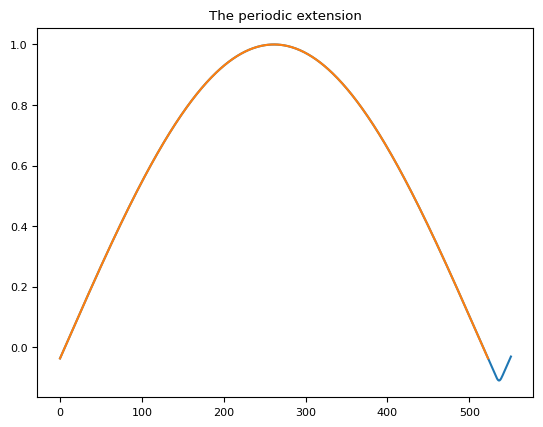

xx:  [-3.68875850e-02 -3.07396541e-02 -2.45917233e-02 -1.84437925e-02
 -1.22958617e-02 -6.14793083e-03  6.93889390e-18  6.14793083e-03
  1.22958617e-02  1.84437925e-02  2.45917233e-02  3.07396541e-02
  3.68875850e-02  4.30355158e-02  4.91834466e-02  5.53313775e-02
  6.14793083e-02  6.76272391e-02  7.37751699e-02  7.99231008e-02
  8.60710316e-02  9.22189624e-02  9.83668933e-02  1.04514824e-01
  1.10662755e-01  1.16810686e-01  1.22958617e-01  1.29106547e-01
  1.35254478e-01  1.41402409e-01  1.47550340e-01  1.53698271e-01
  1.59846202e-01  1.65994132e-01  1.72142063e-01  1.78289994e-01
  1.84437925e-01  1.90585856e-01  1.96733787e-01  2.02881717e-01
  2.09029648e-01  2.15177579e-01  2.21325510e-01  2.27473441e-01
  2.33621371e-01  2.39769302e-01  2.45917233e-01  2.52065164e-01
  2.58213095e-01  2.64361026e-01  2.70508956e-01  2.76656887e-01
  2.82804818e-01  2.88952749e-01  2.95100680e-01  3.01248611e-01
  3.07396541e-01  3.13544472e-01  3.19692403e-01  3.25840334e-01
  3.31988265e-01  3.

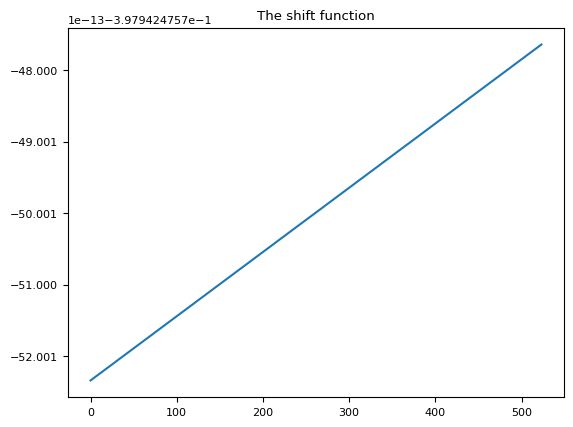

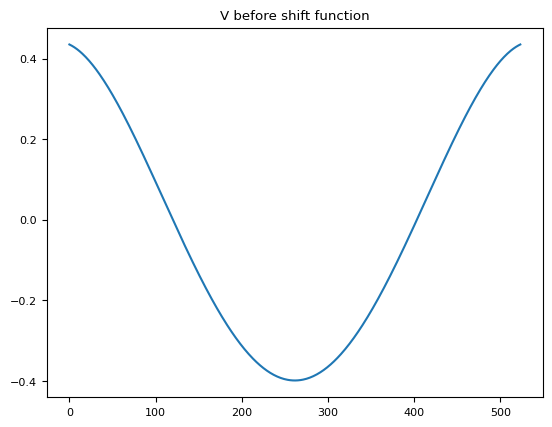

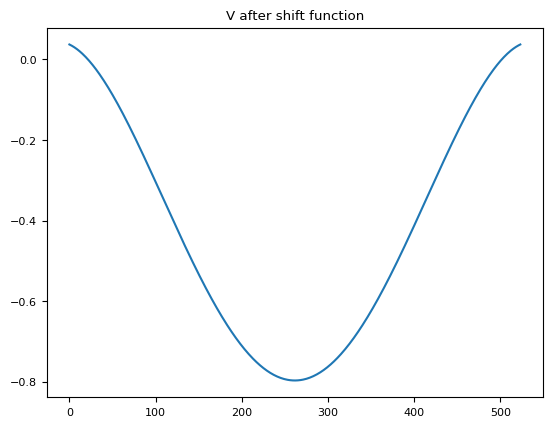

V[0] =  (0.0368792200906482+0j)  V0:  0.036879220090648195  V[-1]:  (0.0368792200906482+0j)  V1  0.036879220090648195


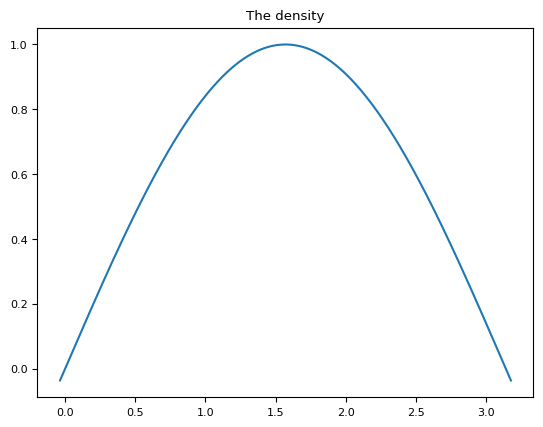

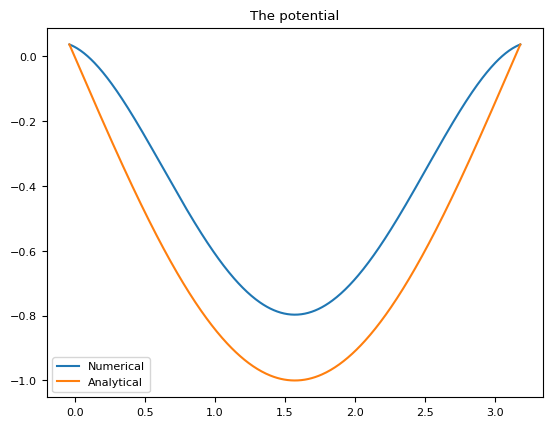

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


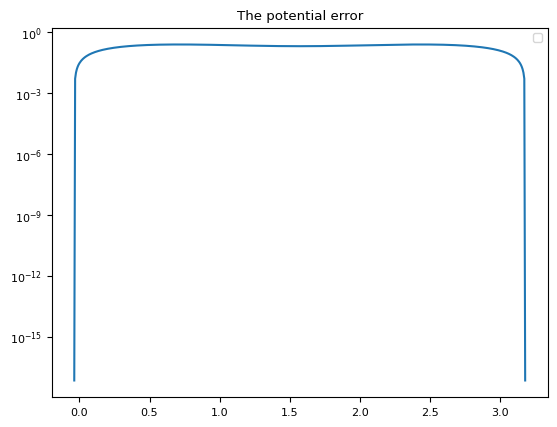

In [56]:
import pandas as pd 


def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=.5, alpha= 1/20, eps=0, L=1, N=100):
    psi = eps + 0j
    N = 40
    L = 1
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 0.001
c["resolution"]                 = 512
c["boundarySize"]               = 6
c["useBC"]                      = True
c["domainSize"]                 = [0.0, np.pi]
c["xlim"]                       = [0.0, np.pi]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["useAdaptiveTimestep"]        = True 
c["C_parabolic"]                = 0.2
c["alpha"]                      = 16 * np.log(10)
c["projectionOrder"]            = 8#12

c["extensionGamma"]             = 150
c["extensionG"]                 = 63

c["inputPrecision"]             = np.cdouble
c["realPrecision"]              = np.double
c["complexPrecision"]           = np.cdouble
c["extensionNDelta"]            = 10
nd = 38
c["extensionND"]                = 28

poisson = GramPoissonScheme(c, periodic1DGaussian)
xx = poisson.grid[0]

def func(x):
    return np.sin(x) 
print(xx)
rho = func(xx) 
V0 = -func(xx[ 0])
V1 = -func(xx[-1])
potential = poisson.solve(rho, V0, V1) 
analyticalPotential =  -func(poisson.grid[0]) 
plt.title("The density")
plt.plot(xx, rho)
plt.show()

plt.title("The potential") 
plt.plot(xx, potential, label="Numerical")
plt.plot(xx, analyticalPotential, label="Analytical")
plt.legend()
plt.show()


plt.title("The potential error") 
plt.yscale("log")
plt.plot(xx, np.abs(analyticalPotential - potential))
plt.legend()
plt.show()
